In [1]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Validation dashboard for inter-cellular trips
Validate the results with VP2030 data

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

## Prepare input data for validation

### VP2030

In [3]:
vp2017 = pd.read_csv(input_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017.set_index(['origin', 'destination'], drop=True, inplace=True)
vp2017.shape

(154842, 25)

In [4]:
segment_dict = {'Fz1':'commuting', 'Fz2':'education', 'Fz3':'shopping/medical', 'Fz4':'business', 'Fz6':'private'}
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}

In [5]:
# Get the columns right
vp2017.columns = pd.MultiIndex.from_tuples(
    [(mode_dict_vp[col.split('_')[0]], col.split('_')[-1])
     for col in vp2017.columns],
    names=['mode', 'segment'])

In [6]:
vp2017.iloc[0:0]

Empty DataFrame
Columns: [(rail, Fz1), (rail, Fz2), (rail, Fz3), (rail, Fz4), (rail, Fz6), (car, Fz1), (car, Fz2), (car, Fz3), (car, Fz4), (car, Fz6), (air, Fz1), (air, Fz2), (air, Fz3), (air, Fz4), (air, Fz6), (bus, Fz1), (bus, Fz2), (bus, Fz3), (bus, Fz4), (bus, Fz6), (walk, Fz1), (walk, Fz2), (walk, Fz3), (walk, Fz4), (walk, Fz6)]
Index: []

[0 rows x 25 columns]

In [7]:
# Prevent small values from being dropped
vp2017 = vp2017 * 1000

### MiD2017

In [8]:
# Load calibration dataset
mid2017 = pd.read_csv(input_path + 'mid2017_validation_normalised.csv')
mid2017.set_index('mode_model', drop=True, inplace=True)
mid2017.shape

(7, 5)

In [9]:
# Merge rail modes and bus and coach
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_agg'] = [mode_dict_mid[i] for i in mid2017.index]

### Model

In [10]:
# We don't need the assignment, just the mode choice
sm = stepmodel.read_json(model_path + 'de_logit')

In [11]:
# Get probabilities in a tidy format
probs = sm.probabilities.set_index(['origin', 'destination', 'segment'])[
        ['walk', 'car', 'air', 'bus', 'coach', 'rail_short_distance', 'rail_long_distance']
    ].stack().rename('probability')
probs.index.set_names('route_type', level=3, inplace=True)

In [12]:
# Merge rail and public road
probs = probs.reset_index().replace(
    {'rail_short_distance': 'rail', 'rail_long_distance': 'rail', 'coach': 'bus'}
).groupby(['origin', 'destination', 'segment', 'route_type']
         ).agg({'probability': 'sum'})

In [13]:
# Merge probabilities and volumes
od = probs.unstack('route_type').merge(vp2017.stack('segment').sum(axis=1).rename('volumes'),
                                       how='right', right_index=True, left_index=True)

In [14]:
# Multiply probabilities with volumes
modes = ['air', 'bus', 'car', 'rail', 'walk']
for m in modes:
    od[m] = od[('probability', m)] * od['volumes']
od = od[modes]

In [15]:
od.loc[(od<0).any(axis=1)]

,,,air,bus,car,rail,walk
origin,destination,segment,,,,,


In [16]:
print(len(od))
od = od.loc[od.notna().all(axis=1)]
print(len(od))

774210
774190


### Distances

In [17]:
# Load centroids to compute a distance matrix
import geopandas as gpd
z = stepmodel.read_json(model_path + 'de_zones')
centr = gpd.GeoDataFrame(z.zones).centroid

In [18]:
distances = pd.DataFrame(index=centr.index)
for i, g in centr.items():
    distances[i] = [g.distance(p) for p in list(centr)]

In [19]:
distances.shape

(401, 401)

## Plot averages

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='shopping/medical'>,
       <AxesSubplot:ylabel='business'>, <AxesSubplot:ylabel='private'>],
      dtype=object)

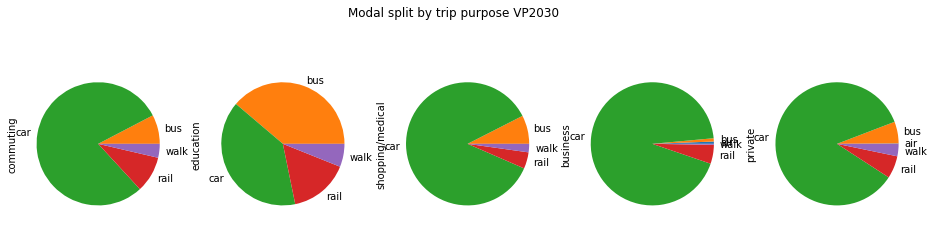

In [20]:
# VP2030
vp2017.T.sum(axis=1).unstack('segment').rename(columns=segment_dict).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose VP2030')

array([<AxesSubplot:ylabel='1'>, <AxesSubplot:ylabel='2'>,
       <AxesSubplot:ylabel='3'>, <AxesSubplot:ylabel='4'>,
       <AxesSubplot:ylabel='6'>], dtype=object)

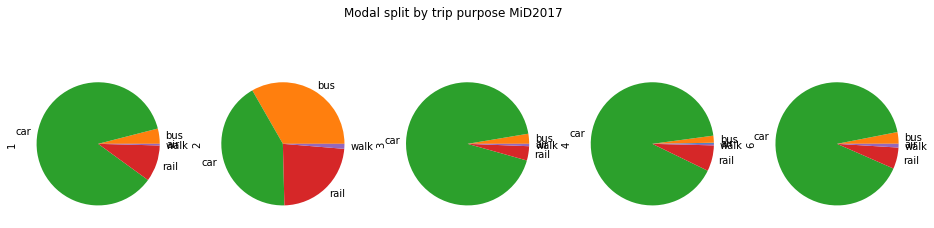

In [21]:
# MiD2017
mid2017.rename(
    columns={1:'commuting', 2:'education', 3:'shopping/medical', 4:'business', 6:'private'}
).groupby('mode_agg').sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose MiD2017')

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='shopping/medical'>,
       <AxesSubplot:ylabel='business'>, <AxesSubplot:ylabel='private'>],
      dtype=object)

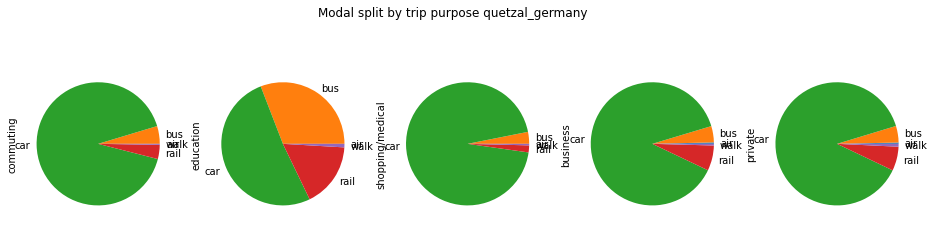

In [22]:
# Model results
od_norm = od.rename(index=segment_dict).unstack('segment').sum().T.unstack('segment')
od_norm = od_norm/(od_norm.max()-od_norm.min()) # Normalise by column
od_norm[['commuting', 'education', 'shopping/medical', 'business', 'private']].plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose quetzal_germany')

<AxesSubplot:ylabel='None'>

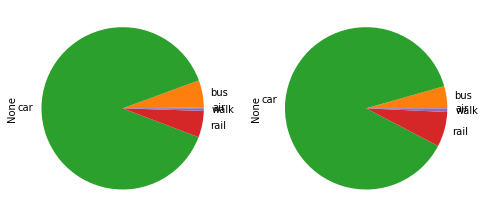

In [23]:
# Overall average compared to MiD2017
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
od.sum().plot.pie(ax=ax[0])
mid2017.groupby('mode_agg').sum().sum(axis=1).plot.pie(ax=ax[1])

In [24]:
# Average probabilities
sm.probabilities.groupby('segment').agg({'walk': 'mean', 'car': 'mean',
                                         'air': 'mean', 'bus': 'mean',
                                         'coach': 'mean', 'rail_short_distance': 'mean',
                                         'rail_long_distance': 'mean'})

,walk,car,air,bus,coach,rail_short_distance,rail_long_distance
segment,,,,,,,
Fz1,0.000017,0.819608,0.159152,0.003316,0.009771,0.002054,0.006083
Fz2,0.000055,0.494114,0.300739,0.020339,0.127402,0.012592,0.044759
Fz3,0.000031,0.881969,0.098686,0.002228,0.009299,0.001248,0.006539
Fz4,0.000039,0.827650,0.054995,0.001618,0.025226,0.025796,0.064677
Fz6,0.000068,0.829344,0.061037,0.002099,0.028886,0.021640,0.056927


In [25]:
# Average utilities
sm.utilities.groupby('segment').agg({'walk': 'mean', 'car': 'mean',
                                     'air': 'mean', 'bus': 'mean',
                                     'coach': 'mean', 'rail_short_distance': 'mean',
                                     'rail_long_distance': 'mean'})

,walk,car,air,bus,coach,rail_short_distance,rail_long_distance
segment,,,,,,,
Fz1,-3.711844,-2.822435,-5.702970,-2.037983,-8.219699,-10.630171,-9.125265
Fz2,-2.944431,-3.335649,-2.996809,0.844225,-5.239460,-8.112801,-6.614837
Fz3,-3.176083,-1.857507,-5.061964,-2.363759,-6.887095,-8.640561,-7.528394
Fz4,-3.116088,0.266076,-1.855189,-1.819740,-2.360080,-2.377857,-2.037772
Fz6,-2.603238,0.051449,-2.048754,-1.830339,-2.642194,-2.779852,-2.398991


### Distance-related

In [26]:
# VP2030 results by distance class (geometric distance between centroids)
dist_max = distances.max().max()
bins = [0,1,2,4,6,9]
t = vp2017.copy() * 100
t['dist'] = [distances.loc[i[0], i[1]] for i in t.index]
t['bins'] = pd.cut(t['dist'], bins=bins,
                   labels=['{}-{}'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)])
t.drop('dist', axis=1, inplace=True)
t2 = od.copy() * 100
t2['dist'] = [distances.loc[i[0], i[1]] for i in t2.index]
t2['bins'] = pd.cut(t2['dist'], bins=bins,
                    labels=['{}-{}'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)])
t2.drop('dist', axis=1, inplace=True)

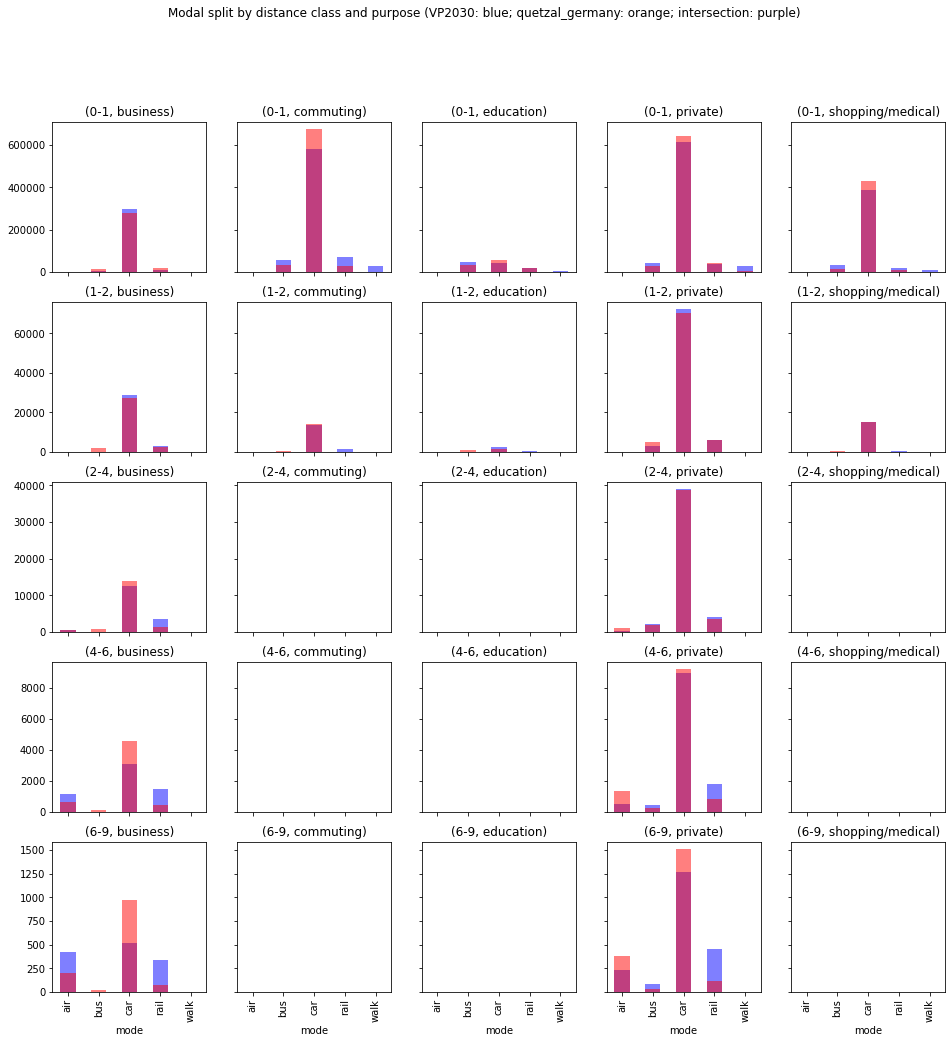

In [27]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,16), sharex='all', sharey='row')
t.groupby('bins').sum(axis=0).rename(columns=segment_dict).stack('segment').T.plot.bar(#.pie(
    ax=ax, subplots=True, legend=False, color='blue', alpha=0.5,
    title='Modal split by distance class and purpose (VP2030: blue; quetzal_germany: orange; intersection: purple)')
t2.unstack('segment').groupby(('bins', 'Fz1')).sum(axis=0).drop('bins', axis=1, level=0).rename(
    columns=segment_dict).T.unstack('segment').plot.bar(
    ax=ax, subplots=True, legend=False, color='red', alpha=0.5)
print(' ')

### Location-related

array([<AxesSubplot:ylabel='DE1'>, <AxesSubplot:ylabel='DE2'>,
       <AxesSubplot:ylabel='DE3'>, <AxesSubplot:ylabel='DE4'>,
       <AxesSubplot:ylabel='DE5'>, <AxesSubplot:ylabel='DE6'>,
       <AxesSubplot:ylabel='DE7'>, <AxesSubplot:ylabel='DE8'>,
       <AxesSubplot:ylabel='DE9'>, <AxesSubplot:ylabel='DEA'>,
       <AxesSubplot:ylabel='DEB'>, <AxesSubplot:ylabel='DEC'>,
       <AxesSubplot:ylabel='DED'>, <AxesSubplot:ylabel='DEE'>,
       <AxesSubplot:ylabel='DEF'>, <AxesSubplot:ylabel='DEG'>],
      dtype=object)

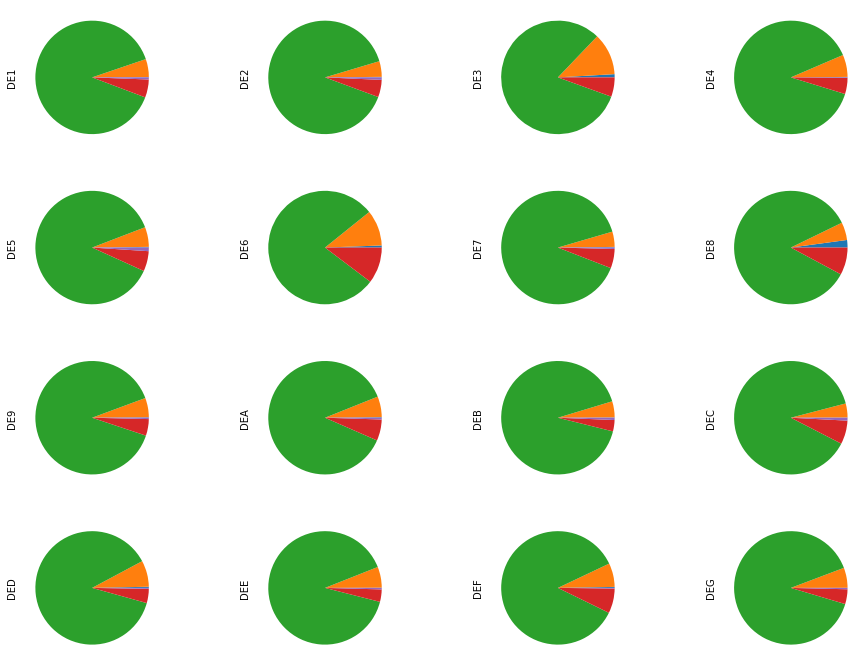

In [28]:
# Average by region (origin)
od['region'] = [s[:3] for s in list(od.reset_index()['origin'])]
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,12))
od.groupby('region').agg({col: 'sum' for col in modes}).T.plot.pie(
    subplots=True, labels=modes,
    startangle=0, counterclock=True,# colors=colors,
    legend=False, labeldistance=None, ax=ax)
#fig.legend()

array([<AxesSubplot:ylabel='DE1'>, <AxesSubplot:ylabel='DE2'>,
       <AxesSubplot:ylabel='DE3'>, <AxesSubplot:ylabel='DE4'>,
       <AxesSubplot:ylabel='DE5'>, <AxesSubplot:ylabel='DE6'>,
       <AxesSubplot:ylabel='DE7'>, <AxesSubplot:ylabel='DE8'>,
       <AxesSubplot:ylabel='DE9'>, <AxesSubplot:ylabel='DEA'>,
       <AxesSubplot:ylabel='DEB'>, <AxesSubplot:ylabel='DEC'>,
       <AxesSubplot:ylabel='DED'>, <AxesSubplot:ylabel='DEE'>,
       <AxesSubplot:ylabel='DEF'>, <AxesSubplot:ylabel='DEG'>],
      dtype=object)

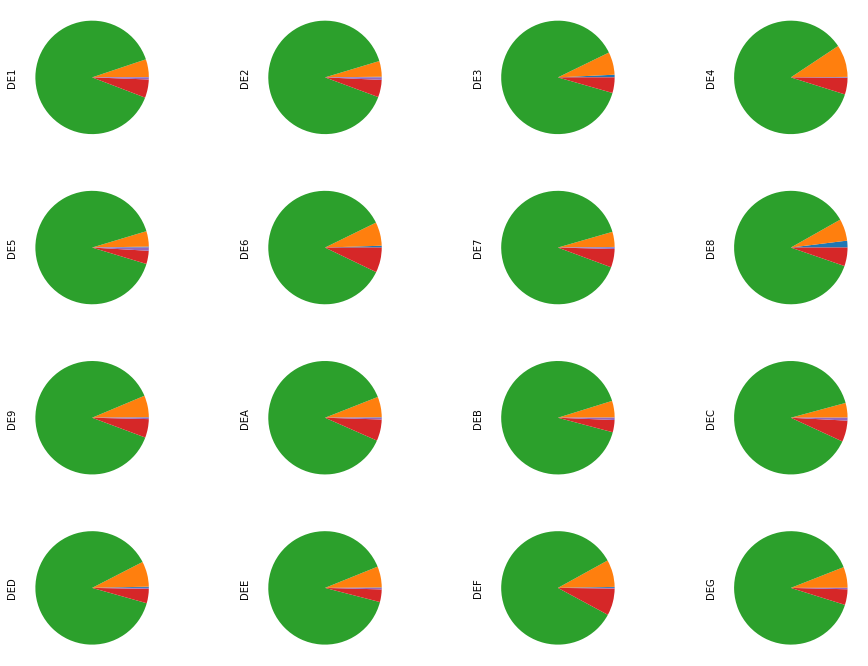

In [29]:
# Average by region (destination)
od['region'] = [s[:3] for s in list(od.reset_index()['destination'])]
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,12))
od.groupby('region').agg({col: 'sum' for col in modes}).T.plot.pie(
    subplots=True, labels=modes,
    startangle=0, counterclock=True,# colors=colors,
    legend=False, labeldistance=None, ax=ax)
#fig.legend()

In [30]:
od.drop('region', axis=1, inplace=True)

## Detailed comparison

Between model results and VP2030 results

In [31]:
# Compare model results and VP2030 in detail
# Merge each OD pair to compare volumes calculated
merged = vp2017.merge(od.unstack('segment').rename(columns={m:m+'_y' for m in od.columns}),
                      left_index=True, right_index=True).replace({np.nan: 0})

(0.0, 20.0)

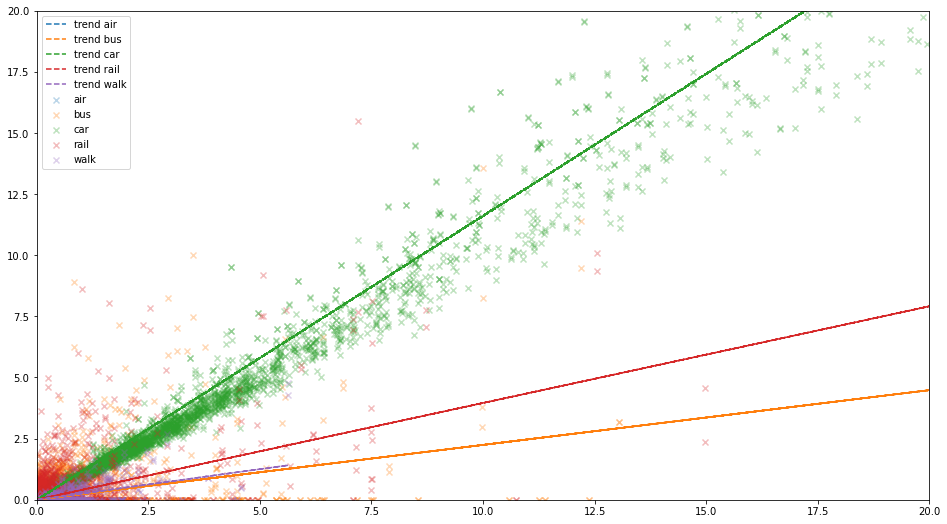

In [32]:
fig, ax = plt.subplots(figsize=(16,9))
for mode in modes:
    x = merged.loc[:, (mode, [k for k,_ in segment_dict.items()])].sum(axis=1)
    y = merged.loc[:, (mode+'_y', [k for k,_ in segment_dict.items()])].sum(axis=1)
    plt.scatter(x, y, marker='x', alpha=.3, label=mode)
    p = np.poly1d(np.polyfit(x, y, deg=1))
    plt.plot(x, p(x), linestyle='--', marker='', label='trend '+mode)
plt.legend()
plt.xlim(0, 20)
plt.ylim(0, 20)

(0.0, 0.5)

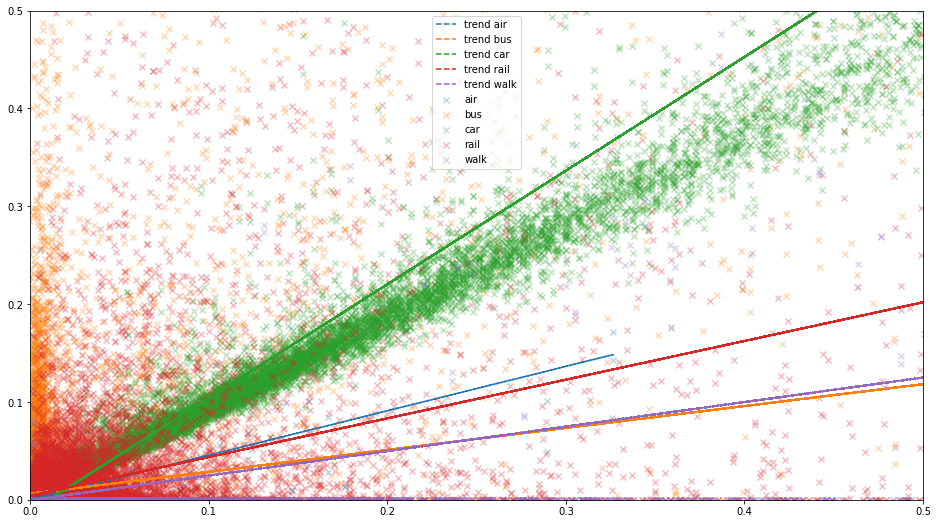

In [33]:
# Zoom
fig, ax = plt.subplots(figsize=(16,9))
for mode in modes:
    x = merged.loc[:, (mode, [k for k,_ in segment_dict.items()])].sum(axis=1)
    y = merged.loc[:, (mode+'_y', [k for k,_ in segment_dict.items()])].sum(axis=1)
    plt.scatter(x, y, marker='x', alpha=.3, label=mode)
    p = np.poly1d(np.polyfit(x, y, deg=1))
    plt.plot(x, p(x), linestyle='--', marker='', label='trend '+mode)
plt.legend()
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

In [34]:
# How good is the fit?
from sklearn.metrics import r2_score
for mode in modes:
    x = merged.loc[:, (mode, [k for k,_ in segment_dict.items()])].sum(axis=1)
    y = merged.loc[:, (mode+'_y', [k for k,_ in segment_dict.items()])].sum(axis=1)
    p = np.poly1d(np.polyfit(x, y, deg=1))
    print('R square for {}: {}'.format(mode, r2_score(y, p(x))))
# Overall fit
x = merged.loc[:, (modes, [k for k,_ in segment_dict.items()])].sum(axis=1)
y = merged.loc[:, ([m+'_y' for m in modes], [k for k,_ in segment_dict.items()])].sum(axis=1)
p = np.poly1d(np.polyfit(x, y, deg=1))
print('Overall R square: {}'.format(r2_score(y, p(x))))

R square for air: 0.45441148469877535
R square for bus: 0.1674351586377718
R square for car: 0.9727856844656753
R square for rail: 0.29241234227838886
R square for walk: 0.3831206347456092
Overall R square: 1.0


In [35]:
# Where are the connections with highest volumes?
from shapely import geometry
high_vol = od.unstack('segment').sum(axis=1).sort_values(0).tail(int(len(od.unstack('segment'))/100))
high_vol = high_vol.reset_index()
centr = gpd.GeoDataFrame(index=centr.index, geometry=list(centr))
high_vol = gpd.GeoDataFrame(high_vol, geometry=[geometry.LineString(
    [centr.loc[row['origin'], 'geometry'], centr.loc[row['destination'], 'geometry']])
                                                for _, row in high_vol.iterrows()])
high_vol.head(2)

,origin,destination,0,geometry
0,DE134,DE135,3.312272,"LINESTRING (8.01631 48.42086, 8.53244 48.25424)"
1,DE135,DE134,3.312272,"LINESTRING (8.53244 48.25424, 8.01631 48.42086)"


<AxesSubplot:>

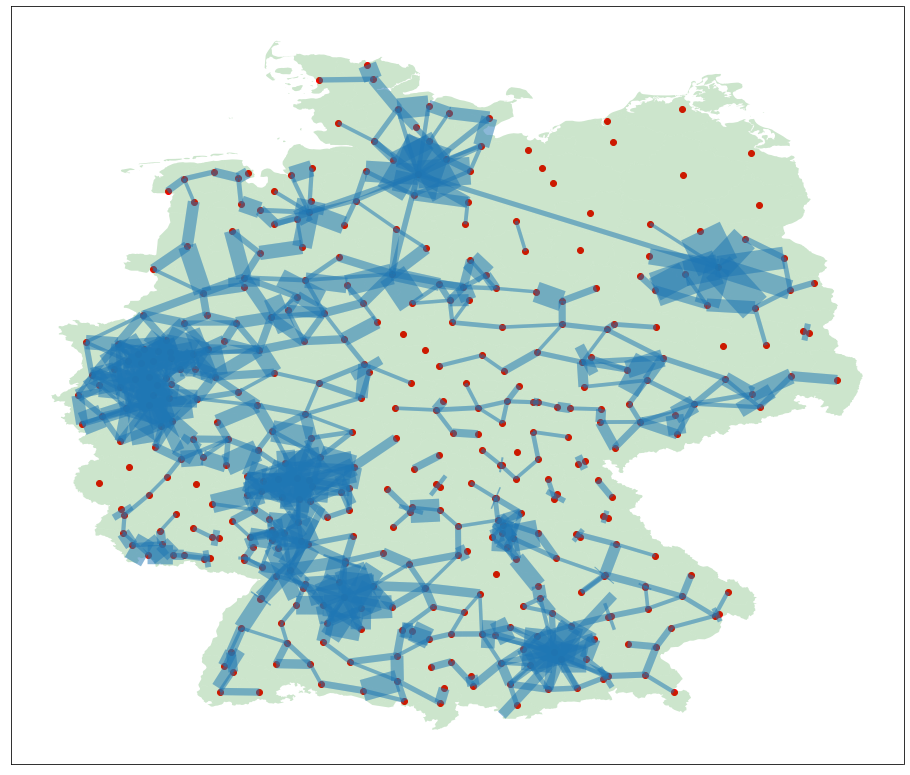

In [36]:
high_vol.plot(alpha=.3, linewidth=list(high_vol[0]),
              ax=z.plot('zones', alpha=.2, color='green',
                        ax=centr.plot(color='red', figsize=(16,16))))